In [1]:
# import os
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' 

import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

2025-03-02 13:20:43.864074: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-02 13:20:43.949740: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-02 13:20:44.001080: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-02 13:20:44.009982: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-02 13:20:44.074662: I tensorflow/core/platform/cpu_feature_guar

In [2]:
import tensorflow as tf
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available: 1


I0000 00:00:1740901847.542183    5368 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1740901847.699375    5368 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1740901847.700711    5368 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


In [3]:
df = pd.read_csv("hingconvoupdated.csv")

# Display first few rows
df.head()

,Conversation
0,Hey Radhika! Kaisi ho?
1,"Hey Rohan, main bilkul thik hun. Tu bata, kais..."
2,"I'm good too, yaar. Tumne suna ki next week sc..."
3,"Haan, mujhe toh pata chal gaya hai. Itna excit..."
4,"Bilkul, Radhika. Ek trip miss karunga toh beha..."


In [4]:
import re

def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r"[^\w\s]", "", text)  # Remove punctuation
    text = re.sub(r"\s+", " ", text).strip()  # Remove extra spaces
    return text

# Apply preprocessing to the conversation column
df["Conversation"] = df["Conversation"].astype(str).apply(preprocess_text)

# Display cleaned text
df.head()


,Conversation
0,hey radhika kaisi ho
1,hey rohan main bilkul thik hun tu bata kaisa hai
2,im good too yaar tumne suna ki next week schoo...
3,haan mujhe toh pata chal gaya hai itna excited...
4,bilkul radhika ek trip miss karunga toh behad ...


In [5]:
#PREPROCESS
import re

def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r"[^\w\s]", "", text)  # Remove punctuation
    text = re.sub(r"\s+", " ", text).strip()  # Remove extra spaces
    return text

# Apply preprocessing to the conversation column
df["Conversation"] = df["Conversation"].astype(str).apply(preprocess_text)

# Display cleaned text
df.head()


,Conversation
0,hey radhika kaisi ho
1,hey rohan main bilkul thik hun tu bata kaisa hai
2,im good too yaar tumne suna ki next week schoo...
3,haan mujhe toh pata chal gaya hai itna excited...
4,bilkul radhika ek trip miss karunga toh behad ...


In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Initialize tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df["Conversation"])

# Convert text to sequences
sequences = tokenizer.texts_to_sequences(df["Conversation"])


In [7]:
# 🚀 Step 4: Prepare Input-Output Data Efficiently
input_sequences = []
output_words = []

# Set a limit on sequence length to prevent memory overload
max_seq_length = 50  # Adjust based on available RAM

for sequence in sequences:
    for i in range(1, min(len(sequence), max_seq_length)):  # Limit sequence expansion
        input_sequences.append(sequence[:i])
        output_words.append(sequence[i])  # Predict the next word

In [8]:
# 🚀 Step 5: Pad Sequences and Convert Output to Sparse Labels
max_sequence_length = max(len(seq) for seq in input_sequences)  # Find max length for padding

X = pad_sequences(input_sequences, maxlen=max_sequence_length, padding="pre")
y = np.array(output_words)  # Use integer encoding instead of one-hot encoding

In [9]:
# 🚀 Step 6: Split Data into Training and Validation Sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Save processed data to avoid recomputation
np.save("X.npy", X)
np.save("y.npy", y)

In [10]:
# 🚀 Step 7: Define Optimized LSTM Model
vocab_size = len(tokenizer.word_index) + 1  # Total unique words
embedding_dim = 100  # Word vector size
lstm_units = 256  # LSTM cell size

lstm_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length),
    LSTM(units=lstm_units, return_sequences=False),
    Dense(units=vocab_size, activation="softmax")
])

# Compile model using sparse categorical crossentropy to reduce memory usage
lstm_model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])


/home/shady/Desktop/project/venv/lib64/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
I0000 00:00:1740901866.682777    5368 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1740901866.685297    5368 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1740901866.687542    5368 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https:

In [11]:
# 🚀 Step 8: Train the Model with Smaller Batch Size
history = lstm_model.fit(X_train, y_train, epochs=2, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/2
   1/4579 ━━━━━━━━━━━━━━━━━━━━ 1:41:36 1s/step - accuracy: 0.0000e+00 - loss: 9.2079

2025-03-02 13:21:10.881740: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


4579/4579 ━━━━━━━━━━━━━━━━━━━━ 30s 6ms/step - accuracy: 0.0646 - loss: 6.7232 - val_accuracy: 0.1434 - val_loss: 5.5887
Epoch 2/2
4579/4579 ━━━━━━━━━━━━━━━━━━━━ 29s 6ms/step - accuracy: 0.1622 - loss: 5.1959 - val_accuracy: 0.1795 - val_loss: 5.2532


In [12]:
lstm_model.save("hinglish_lstm_model.keras")

In [13]:
# 🚀 Step 10: Function to Predict the Next Word
def predict_next_word(input_text, tokenizer, model, max_sequence_length):
    input_text = preprocess_text(input_text)  # Apply preprocessing
    sequence = tokenizer.texts_to_sequences([input_text])[0]  # Tokenize input
    sequence = pad_sequences([sequence], maxlen=max_sequence_length, padding="pre")  # Pad sequence

    predicted_index = np.argmax(model.predict(sequence), axis=-1)  # Get most probable word index
    predicted_word = tokenizer.index_word.get(predicted_index[0], "")  # Convert index to word

    return predicted_word

In [14]:
# 🚀 Step 11: Prompt User Input and Predict Top 3 Next Words
def predict_top_words(input_text, tokenizer, model, max_sequence_length, top_n=3):
    input_text = preprocess_text(input_text)  # Apply preprocessing
    sequence = tokenizer.texts_to_sequences([input_text])[0]  # Tokenize input
    sequence = pad_sequences([sequence], maxlen=max_sequence_length, padding="pre")  # Pad sequence

    predictions = model.predict(sequence)[0]  # Get probability distribution
    top_indices = np.argsort(predictions)[-top_n:][::-1]  # Get top N word indices

    top_words = [tokenizer.index_word.get(idx, "") for idx in top_indices]  # Convert indices to words

    return top_words

# Prompt user for input text
input_text = input("Enter a Hinglish phrase: ")

# Predict top 3 most probable next words
predicted_words = predict_top_words(input_text, tokenizer, lstm_model, max_sequence_length)
print(f"Predicted next words: {predicted_words}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
Predicted next words: ['hai', 'hoon', 'hu']


In [15]:
#Step 12: Implement BiLSTM & GRU Models
from tensorflow.keras.layers import Bidirectional

# 🚀 Define BiLSTM Model
bilstm_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length),
    Bidirectional(LSTM(units=lstm_units, return_sequences=False)),  # Bidirectional LSTM
    Dense(units=vocab_size, activation="softmax")
])

# Compile the BiLSTM model
bilstm_model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# 🚀 Train the BiLSTM Model
history_bilstm = bilstm_model.fit(X_train, y_train, epochs=2, batch_size=32, validation_data=(X_val, y_val))

# Save the BiLSTM Model
bilstm_model.save("hinglish_bilstm_model.keras")


Epoch 1/2
4579/4579 ━━━━━━━━━━━━━━━━━━━━ 47s 10ms/step - accuracy: 0.0664 - loss: 6.6759 - val_accuracy: 0.1471 - val_loss: 5.5455
Epoch 2/2
4579/4579 ━━━━━━━━━━━━━━━━━━━━ 46s 10ms/step - accuracy: 0.1668 - loss: 5.1569 - val_accuracy: 0.1839 - val_loss: 5.2209


In [16]:
# implement GRU
from tensorflow.keras.layers import GRU

# 🚀 Define GRU Model
gru_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length),
    GRU(units=lstm_units, return_sequences=False),  # GRU Layer
    Dense(units=vocab_size, activation="softmax")
])

# Compile the GRU model
gru_model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# 🚀 Train the GRU Model
history_gru = gru_model.fit(X_train, y_train, epochs=2, batch_size=32, validation_data=(X_val, y_val))

# Save the GRU Model
gru_model.save("hinglish_gru_model.keras")

Epoch 1/2
4579/4579 ━━━━━━━━━━━━━━━━━━━━ 29s 6ms/step - accuracy: 0.0766 - loss: 6.6201 - val_accuracy: 0.1600 - val_loss: 5.4228
Epoch 2/2
4579/4579 ━━━━━━━━━━━━━━━━━━━━ 28s 6ms/step - accuracy: 0.1847 - loss: 4.9386 - val_accuracy: 0.1979 - val_loss: 5.1186


## BiLSTM- GRU

In [17]:
from tensorflow.keras.layers import Bidirectional, GRU

# 🚀 Define Hybrid BiLSTM-GRU Model
bilstm_gru_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length),
    Bidirectional(LSTM(units=lstm_units, return_sequences=True)),  # Return full sequence for the GRU
    GRU(units=lstm_units, return_sequences=False),  # Process the sequence output from BiLSTM
    Dense(units=vocab_size, activation="softmax")
])

# Compile the model
bilstm_gru_model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# Train the model
history_bilstm_gru = bilstm_gru_model.fit(X_train, y_train, epochs=2, batch_size=32, validation_data=(X_val, y_val))

# Save the model
bilstm_gru_model.save("hinglish_bilstm_gru_model.keras")


Epoch 1/2
4579/4579 ━━━━━━━━━━━━━━━━━━━━ 48s 10ms/step - accuracy: 0.0708 - loss: 6.6576 - val_accuracy: 0.1515 - val_loss: 5.5039
Epoch 2/2
4579/4579 ━━━━━━━━━━━━━━━━━━━━ 47s 10ms/step - accuracy: 0.1716 - loss: 5.0828 - val_accuracy: 0.1885 - val_loss: 5.1502


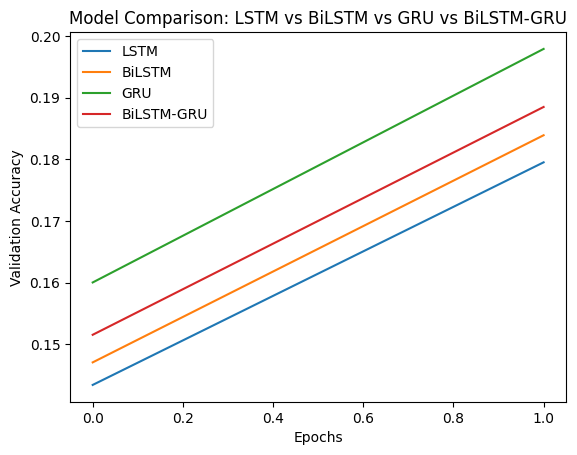

In [20]:
import matplotlib.pyplot as plt

# Plot validation accuracy for all models
plt.plot(history.history['val_accuracy'], label='LSTM')
plt.plot(history_bilstm.history['val_accuracy'], label='BiLSTM')
plt.plot(history_gru.history['val_accuracy'], label='GRU')
plt.plot(history_bilstm_gru.history['val_accuracy'], label='BiLSTM-GRU')  # New hybrid model

plt.title('Model Comparison: LSTM vs BiLSTM vs GRU vs BiLSTM-GRU')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.show()


In [18]:
import os

# Get absolute paths of model files
print(os.path.abspath("hinglish_lstm_model.h5"))
print(os.path.abspath("hinglish_bilstm_model.h5"))
print(os.path.abspath("hinglish_gru_model.h5"))



/home/shady/Desktop/project/hinglish_lstm_model.h5
/home/shady/Desktop/project/hinglish_bilstm_model.h5
/home/shady/Desktop/project/hinglish_gru_model.h5


## COMPARE ALLN THE MODELS

In [21]:
from tensorflow.keras.models import load_model

# Load all trained models
lstm_model = load_model("hinglish_lstm_model.keras")
bilstm_model = load_model("hinglish_bilstm_model.keras")
gru_model = load_model("hinglish_gru_model.keras")
bilstm_gru_model = load_model("hinglish_bilstm_gru_model.keras")  # New hybrid model

# 🚀 Function to Predict Next Words Using a Selected Model
def predict_next_words(input_text, model_choice, tokenizer, max_sequence_length, top_n=3):
    input_text = preprocess_text(input_text)  # Apply preprocessing
    sequence = tokenizer.texts_to_sequences([input_text])[0]  # Tokenize input
    sequence = pad_sequences([sequence], maxlen=max_sequence_length, padding="pre")  # Pad sequence

    # Convert user input to lowercase to make it case-insensitive
    model_choice = model_choice.strip().lower()

    # Select model based on user input
    if model_choice == "lstm":
        model = lstm_model
    elif model_choice == "bilstm":
        model = bilstm_model
    elif model_choice == "gru":
        model = gru_model
    elif model_choice in ["bilstm-gru", "bilstmgru"]:
        model = bilstm_gru_model
    else:
        print("Invalid model choice! Using LSTM by default.")
        model = lstm_model

    predictions = model.predict(sequence)[0]  # Get probability distribution
    top_indices = np.argsort(predictions)[-top_n:][::-1]  # Get top N word indices
    top_words = [tokenizer.index_word.get(idx, "") for idx in top_indices]  # Convert indices to words

    return top_words

# 🚀 User Prompt to Select Model and Input Text
model_choice = input("Choose a model (LSTM / BiLSTM / GRU / BiLSTM-GRU): ").strip().lower()
input_text = input("Enter a Hinglish phrase: ")

# Predict using the chosen model
predicted_words = predict_next_words(input_text, model_choice, tokenizer, max_sequence_length)
print(f"Predicted next words using {model_choice.upper()}: {predicted_words}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
Predicted next words using BILSTM-GRU: ['hai', 'hoon', 'ho']
